In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from sklearn.decomposition import KernelPCA

path_spektri = '/home/jurijs/Documents/Faks/PSUF/nal_2/spektri/'
#path_spektri = '/home/jurij/Documents/Faks/PSUF/nal_2/spektri/'
#path = '/home/jurij/Documents/Faks/PSUF/nal_2/'
path = '/home/jurijs/Documents/Faks/PSUF/nal_2/'

# LOAD DATA

In [30]:
# Load wavelength grid (Ångström)
wav = np.loadtxt(path_spektri + 'val.dat', comments='#')

# Choose which spectra to load (example: first 5)
spec_ids = np.arange(1,10,1)

spectra = []
for sid in spec_ids:
    flux = np.loadtxt(path_spektri + f'{sid}.dat', comments='#')
    spectra.append(flux)

spectra = np.array(spectra)  # shape: (n_spectra, n_points)

# PLOT RAW SPECTRA

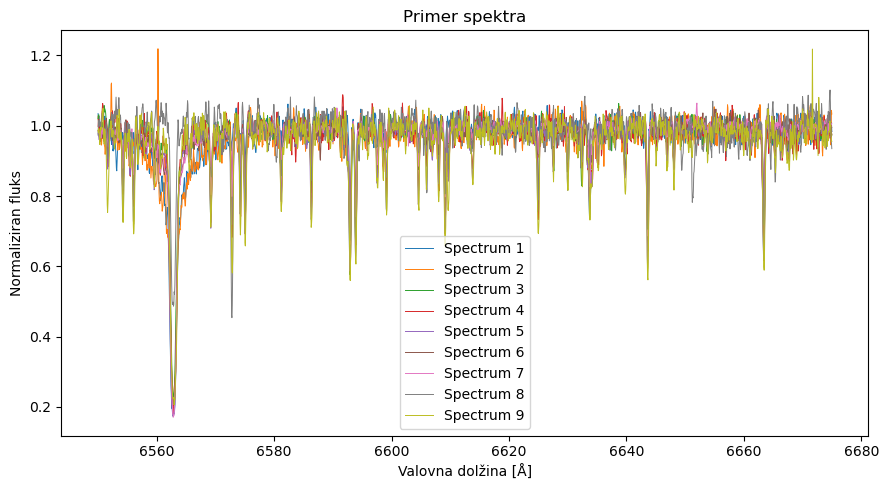

In [31]:
plt.figure(figsize=(9, 5))
for i, flux in enumerate(spectra):
    plt.plot(wav, flux, label=f'Spectrum {spec_ids[i]}', lw = 0.7)
plt.xlabel('Valovna dolžina [Å]')
plt.ylabel('Normaliziran fluks')
plt.title('Primer spektra')
plt.legend()
plt.tight_layout()
plt.show()

# FIND OUTLIER SPECTRA

Spectra ranked by distance from mean:
1. Spectrum 8 — distance = 2.5553
2. Spectrum 1 — distance = 1.8460
3. Spectrum 9 — distance = 1.7664
4. Spectrum 2 — distance = 1.7369
5. Spectrum 4 — distance = 1.2177
6. Spectrum 5 — distance = 1.0867
7. Spectrum 6 — distance = 1.0061
8. Spectrum 3 — distance = 0.9840
9. Spectrum 7 — distance = 0.9038


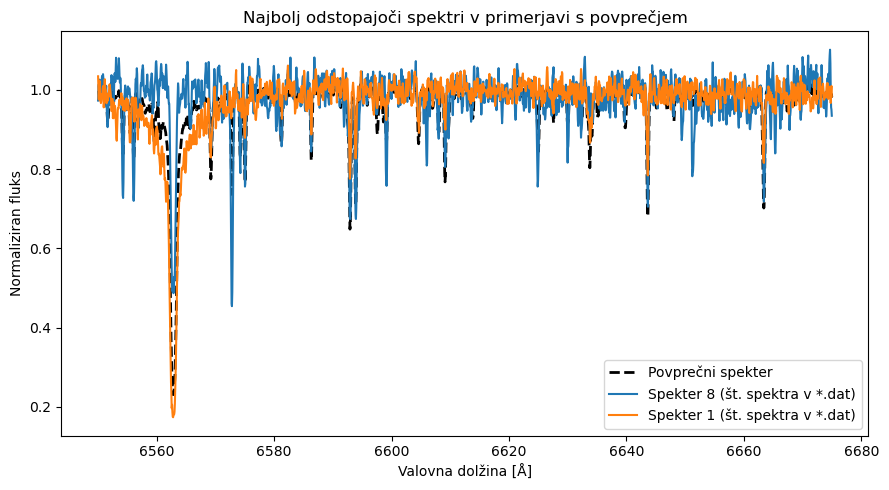

In [32]:
# Compute mean spectrum
mean_spec = np.mean(spectra, axis=0)

# Compute Euclidean distance from mean for each spectrum
distances = [euclidean(spec, mean_spec) for spec in spectra]

# Sort by distance (largest = most different)
sorted_indices = np.argsort(distances)[::-1]

print("Spectra ranked by distance from mean:")
for rank, idx in enumerate(sorted_indices, start=1):
    print(f"{rank}. Spectrum {spec_ids[idx]} — distance = {distances[idx]:.4f}")



# VISUALIZE OUTLIERS VS MEAN


plt.figure(figsize=(9, 5))
plt.plot(wav, mean_spec, 'k--', lw=2, label='Povprečni spekter')

# Plot the two most deviant spectra
for i in sorted_indices[:2]:
    plt.plot(wav, spectra[i], label=f'Spekter {spec_ids[i]} (št. spektra v *.dat)')

plt.xlabel('Valovna dolžina [Å]')
plt.ylabel('Normaliziran fluks')
plt.title('Najbolj odstopajoči spektri v primerjavi s povprečjem')
plt.legend()
plt.tight_layout()
plt.show()

# PCA

In [33]:
spec_ids = np.arange(1,10000,1)
spectra = []
for sid in spec_ids:
    flux = np.loadtxt(path_spektri + f'{sid}.dat', comments='#')
    spectra.append(flux)

spectra = np.array(spectra)  # shape: (n_spectra, n_points)
X = np.array(spectra)

# Compute distance from mean for all spectra (assuming X shape = [n, p])
mean_spec = np.mean(X, axis=0)
distances = np.linalg.norm(X - mean_spec, axis=1)

# Determine threshold for top 0.5% most deviant
threshold = np.percentile(distances, 99.5)
outlier_indices = np.where(distances >= threshold)[0]

print(f"Number of outliers: {len(outlier_indices)}")

# IDENTIFY OUTLIER SPECTRA

mean_spec = np.mean(X, axis=0)
distances = [euclidean(spec, mean_spec) for spec in X]
outlier_idx = np.argsort(distances)[-len(outlier_indices):]
print("Outlier spectra:", [spec_ids[i] for i in outlier_idx])

print("Data matrix shape:", X.shape)


# CENTER THE DATA

# Subtract the mean flux at each wavelength bin (feature)
mean_spectrum = np.mean(X, axis=0)
B = X - mean_spectrum


# COMPUTE COVARIANCE MATRIX

# C = (1 / (n - 1)) * B^T * B
n_samples = X.shape[0]
C = np.dot(B.T, B) / (n_samples - 1)

# EIGENDECOMPOSITION

# Find eigenvalues and eigenvectors of covariance matrix
eigvals, eigvecs = np.linalg.eig(C)

# Sort eigenvalues (and eigenvectors) from largest to smallest
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# PROJECT DATA INTO REDUCED SPACE

# Choose number of components q (e.g. first 2 or enough to explain 90% variance)
q = 101
W = eigvecs[:, :q]         # projection matrix (p × q)
T = np.dot(B, W)           # projected data (n × q)

print(f"Projected data shape: {T.shape}")

Number of outliers: 50
Outlier spectra: [1743, 4178, 2265, 776, 3770, 4176, 5632, 3435, 3446, 367, 2379, 4764, 997, 5215, 1367, 1515, 1813, 1309, 1362, 373, 2257, 1233, 328, 2544, 326, 1349, 865, 2295, 2816, 701, 442, 4564, 1350, 294, 434, 5683, 2313, 3189, 2419, 3827, 4055, 4563, 333, 1360, 2001, 1133, 4142, 1363, 2061, 2212]
Data matrix shape: (9999, 2084)
Projected data shape: (9999, 101)


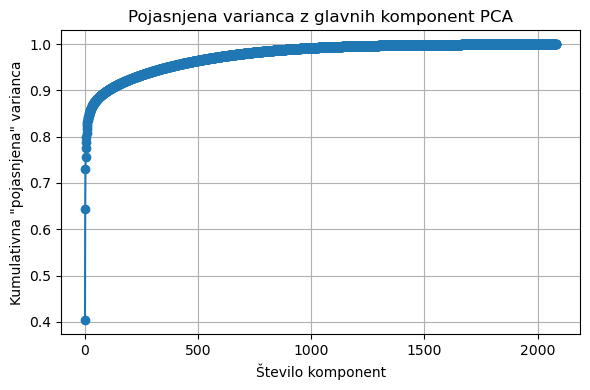

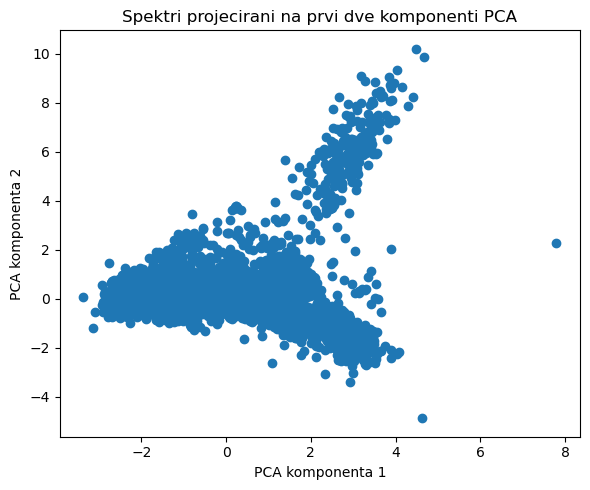

In [34]:
# VARIANCE EXPLAINED

variance_ratio = eigvals / np.sum(eigvals)
cumulative_variance = np.cumsum(variance_ratio)

plt.figure(figsize=(6,4))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Število komponent')
plt.ylabel('Kumulativna "pojasnjena" varianca')
plt.title('Pojasnjena varianca z glavnih komponent PCA')
plt.grid(True)
plt.tight_layout()
plt.show()


# VISUALIZE PCA PROJECTION (2D)

plt.figure(figsize=(6,5))
plt.scatter(T[:,0], T[:,1], c='tab:blue')
plt.xlabel('PCA komponenta 1')
plt.ylabel('PCA komponenta 2')
plt.title('Spektri projecirani na prvi dve komponenti PCA')
plt.tight_layout()
plt.show()


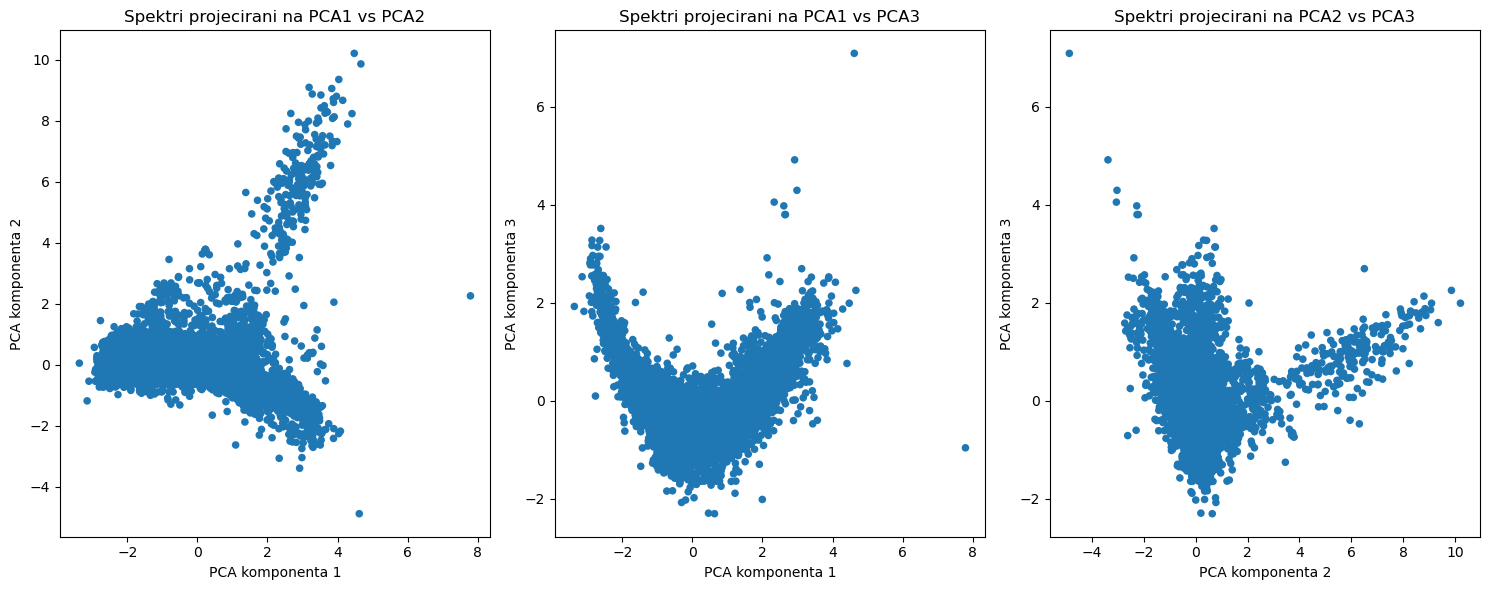

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

pairs = [(0, 1), (0, 2), (1, 2)]
titles = ['PCA1 vs PCA2', 'PCA1 vs PCA3', 'PCA2 vs PCA3']

for ax, (x, y), title in zip(axes, pairs, titles):
    sc = ax.scatter(T[:, x], T[:, y], s=30, edgecolors='none')
    ax.set_xlabel(f'PCA komponenta {x+1}')
    ax.set_ylabel(f'PCA komponenta {y+1}')
    ax.set_title(f'Spektri projecirani na {title}')

plt.tight_layout()
plt.show()

Number of components for >=90% variance: 101


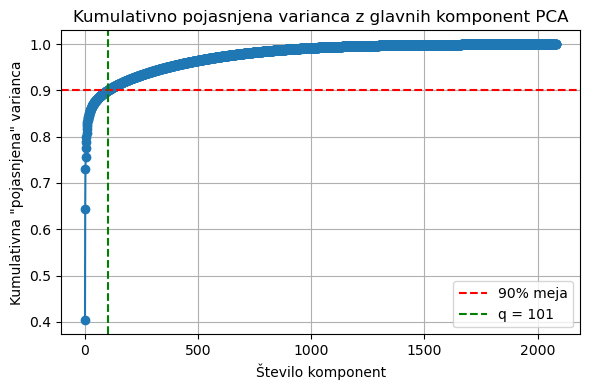

Projected data shape: (9999, 101)


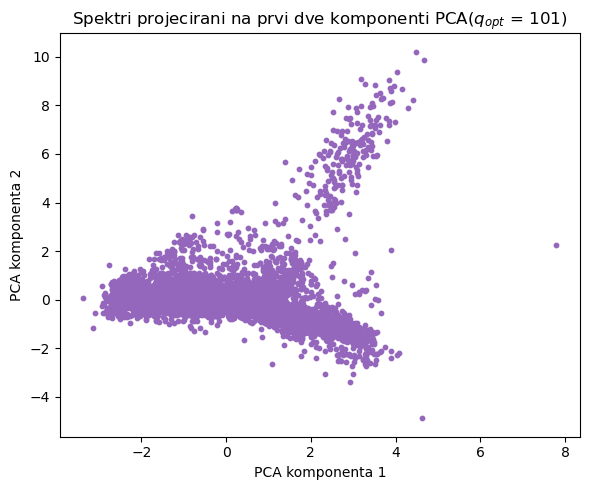

In [7]:
spec_ids = np.arange(1,10000,1)
spectra = [np.loadtxt(path_spektri + f"{sid}.dat", comments="#") for sid in spec_ids]
X = np.array(spectra)  # shape: (n_spectra, n_wavelengths)


# CENTER DATA

mean_spectrum = np.mean(X, axis=0)
B = X - mean_spectrum


# COVARIANCE MATRIX

n_samples = X.shape[0]
C = np.dot(B.T, B) / (n_samples - 1)


# EIGENDECOMPOSITION

eigvals, eigvecs = np.linalg.eig(C)

# Sort eigenvalues (and vectors) descending
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]


# ARIANCE EXPLAINED

variance_ratio = eigvals / np.sum(eigvals)
cumulative_variance = np.cumsum(variance_ratio)

# Automatically find number of components covering >= 90% variance
threshold = 0.90
q_opt = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components for >=90% variance: {q_opt}")


# ISUALIZE VARIANCE

plt.figure(figsize=(6,4))
plt.plot(cumulative_variance, 'o-', color='tab:blue')
plt.axhline(y=threshold, color='r', linestyle='--', label='90% meja')
plt.axvline(x=q_opt, color='g', linestyle='--', label=f'q = {q_opt}')
plt.xlabel('Število komponent')
plt.ylabel('Kumulativna "pojasnjena" varianca')
plt.title('Kumulativno pojasnjena varianca z glavnih komponent PCA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# PROJECT ONTO FIRST q_opt COMPONENTS

W = eigvecs[:, :q_opt]   # projection matrix (p × q_opt)
T = np.dot(B, W)         # projected data (n × q_opt)
print(f"Projected data shape: {T.shape}")


# OPTIONAL 2D VISUALIZATION

if q_opt >= 2:
    plt.figure(figsize=(6,5))
    plt.scatter(T[:,0], T[:,1], c='tab:purple', s = 10)
    plt.xlabel('PCA komponenta 1')
    plt.ylabel('PCA komponenta 2')
    plt.title(f'Spektri projecirani na prvi dve komponenti PCA'+r'($q_{opt}$'+f' = {q_opt})')
    plt.tight_layout()
    plt.show()

# first 2 or 3 PCA components (3)

In [20]:
# Load wavelengths (for reference)
wav = np.loadtxt(path_spektri + "val.dat", comments="#")

# Load training set parameters (if available)
# Columns: spectrum_id, Teff, logg, [M/H]
param_data = np.loadtxt(path + "learning_set_parameters.txt", comments="#")
spec_param_id = param_data[:, 0].astype(int)
Teff = param_data[:, 1]
logg = param_data[:, 2]
MH = param_data[:, 3]

# Match parameter values to the loaded spectra (if IDs overlap)
Teff_match, logg_match, MH_match = [], [], []
for sid in spec_ids:
    if sid in spec_param_id:
        idx = np.where(spec_param_id == sid)[0][0]
        Teff_match.append(Teff[idx])
        logg_match.append(logg[idx])
        MH_match.append(MH[idx])
    else:
        Teff_match.append(np.nan)
        logg_match.append(np.nan)
        MH_match.append(np.nan)

Teff_match = np.array(Teff_match)
logg_match = np.array(logg_match)
MH_match = np.array(MH_match)


# IDENTIFY OUTLIERS (FROM STEP 1)

mean_spec = np.mean(X, axis=0)
distances = [euclidean(spec, mean_spec) for spec in X]
outlier_idx = np.argsort(distances)[-10:]  # 2 most deviant
print("Outlier spectra:", [spec_ids[i] for i in outlier_idx])


# PCA COMPUTATION (from previous step)

# Center data
B = X - np.mean(X, axis=0)
C = np.dot(B.T, B) / (X.shape[0] - 1)
eigvals, eigvecs = np.linalg.eig(C)

# Sort descending
idx = np.argsort(eigvals)[::-1]
eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

# Project onto first 3 components
W = eigvecs[:, :3]
T = np.dot(B, W)


Outlier spectra: [4055, 4563, 333, 1360, 2001, 1133, 4142, 1363, 2061, 2212]


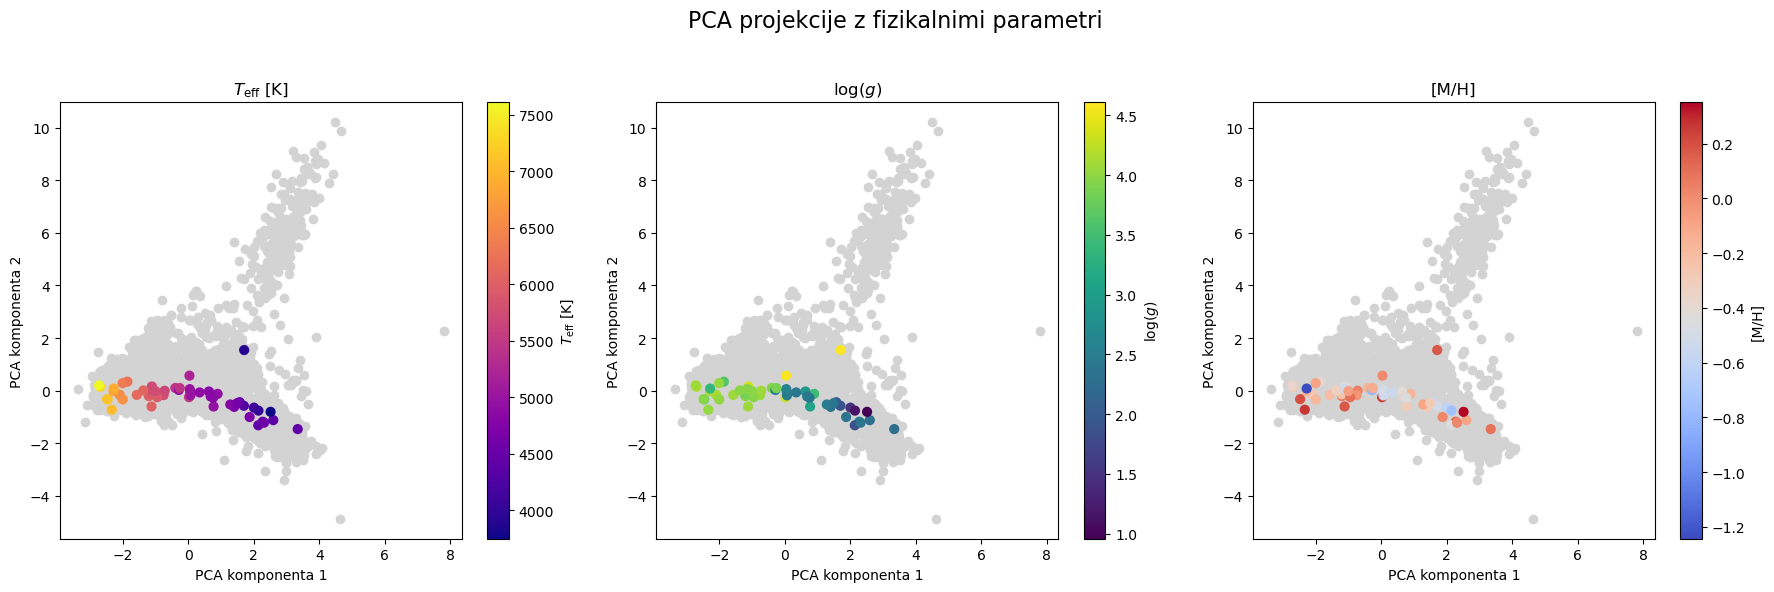

In [22]:
# Plot PCA projections colored by Teff, logg, and [M/H] on the same figure

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Temperature
if not np.isnan(Teff_match).all():
    axes[0].scatter(T[:,0], T[:,1], c='lightgray', label='Spektri')
    sc1 = axes[0].scatter(T[:,0], T[:,1], c=Teff_match, cmap='plasma', s=40)
    axes[0].set_title(r'$T_{\mathrm{eff}}$ [K]')
    axes[0].set_xlabel('PCA komponenta 1')
    axes[0].set_ylabel('PCA komponenta 2')
    fig.colorbar(sc1, ax=axes[0], label=r'$T_{\mathrm{eff}}$ [K]')

# log(g)
if not np.isnan(logg_match).all():
    axes[1].scatter(T[:,0], T[:,1], c='lightgray', label='Spektri')
    sc2 = axes[1].scatter(T[:,0], T[:,1], c=logg_match, cmap='viridis', s=40)

    axes[1].set_title(r'$\log(g)$')
    axes[1].set_xlabel('PCA komponenta 1')
    axes[1].set_ylabel('PCA komponenta 2')
    fig.colorbar(sc2, ax=axes[1], label=r'$\log(g)$')

# Metallicity [M/H]
if not np.isnan(MH_match).all():
    axes[2].scatter(T[:,0], T[:,1], c='lightgray', label='Spektri')
    sc3 = axes[2].scatter(T[:,0], T[:,1], c=MH_match, cmap='coolwarm', s=40)
    axes[2].set_title('[M/H]')
    axes[2].set_xlabel('PCA komponenta 1')
    axes[2].set_ylabel('PCA komponenta 2')
    fig.colorbar(sc3, ax=axes[2], label='[M/H]')

fig.suptitle('PCA projekcije z fizikalnimi parametri', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Computes cumulative variance (4)

In [40]:
# Load training parameters (Teff, logg, [M/H])
param_data = np.loadtxt(path + "learning_set_parameters.txt", comments="#")
spec_param_id = param_data[:, 0].astype(int)
Teff = param_data[:, 1]
logg = param_data[:, 2]
MH = param_data[:, 3]

# Match available parameters to loaded spectra
Teff_match, logg_match, MH_match = [], [], []
for sid in spec_ids:
    if sid in spec_param_id:
        idx = np.where(spec_param_id == sid)[0][0]
        Teff_match.append(Teff[idx])
        logg_match.append(logg[idx])
        MH_match.append(MH[idx])
    else:
        Teff_match.append(np.nan)
        logg_match.append(np.nan)
        MH_match.append(np.nan)

Teff_match = np.array(Teff_match)
logg_match = np.array(logg_match)
MH_match = np.array(MH_match)


# PCA COMPUTATION

# Center data
B = X - np.mean(X, axis=0)
C = np.dot(B.T, B) / (X.shape[0] - 1)

# Eigen decomposition
eigvals, eigvecs = np.linalg.eig(C)

# Sort eigenvalues descending
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]


# VARIANCE ANALYSIS

variance_ratio = eigvals / np.sum(eigvals)
cumulative_variance = np.cumsum(variance_ratio)

# Determine number of components for ≥90% variance
threshold = 0.90
q_opt = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components explaining ≥90% variance: {q_opt}")


Number of components explaining ≥90% variance: 101


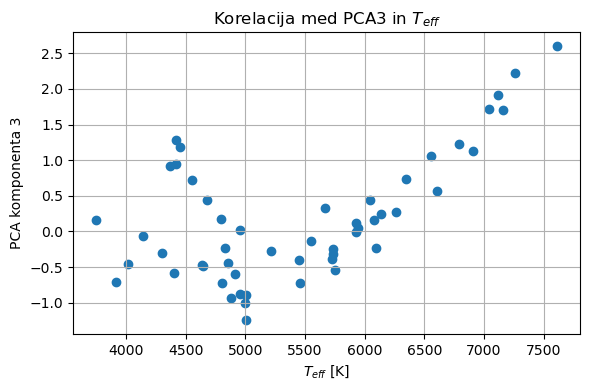

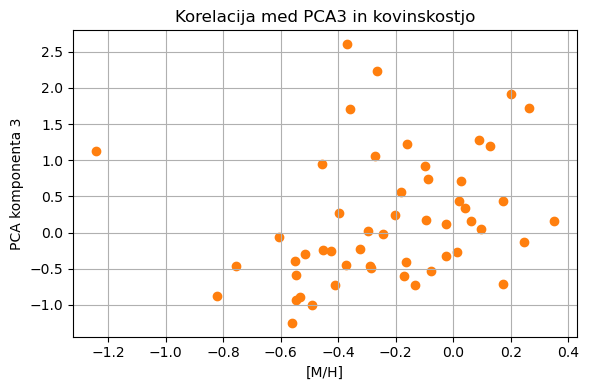

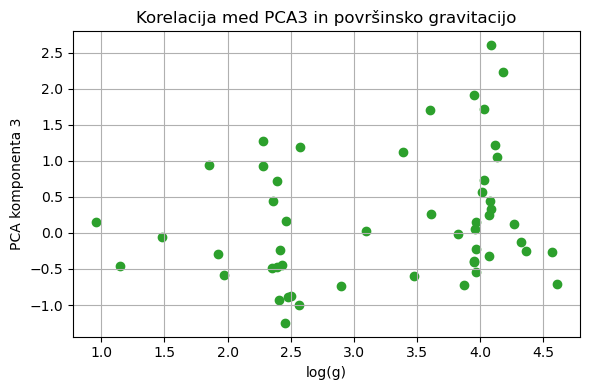

In [42]:
# PROJECT DATA AND CHECK PHYSICAL TRENDS

# Project onto the first few components
W = eigvecs[:, :3]
T = np.dot(B, W)

# Plot the first PCA component vs. Teff, [M/H], log g
if not np.isnan(Teff_match).all():
    plt.figure(figsize=(6,4))
    plt.scatter(Teff_match, T[:,2], color='tab:blue')
    plt.xlabel(r'$T_{eff}$ [K]')
    plt.ylabel('PCA komponenta 3')
    plt.title('Korelacija med PCA3 in $T_{eff}$')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if not np.isnan(MH_match).all():
    plt.figure(figsize=(6,4))
    plt.scatter(MH_match, T[:,2], color='tab:orange')
    plt.xlabel('[M/H]')
    plt.ylabel('PCA komponenta 3')
    plt.title('Korelacija med PCA3 in kovinskostjo')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if not np.isnan(logg_match).all():
    plt.figure(figsize=(6,4))
    plt.scatter(logg_match, T[:,2], color='tab:green')
    plt.xlabel('log(g)')
    plt.ylabel('PCA komponenta 3')
    plt.title('Korelacija med PCA3 in površinsko gravitacijo')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Analyze structure in PCA space

Labels for loaded spectra: {1: 'UNKNOWN', 2: 'UNKNOWN', 3: 'UNKNOWN', 4: 'UNKNOWN', 5: 'UNKNOWN', 6: 'UNKNOWN', 7: 'UNKNOWN', 8: 'UNKNOWN', 9: 'UNKNOWN', 10: 'UNKNOWN', 11: 'UNKNOWN', 12: 'UNKNOWN', 13: 'UNKNOWN', 14: 'UNKNOWN', 15: 'UNKNOWN', 16: 'UNKNOWN', 17: 'UNKNOWN', 18: 'UNKNOWN', 19: 'UNKNOWN', 20: 'UNKNOWN', 21: 'UNKNOWN', 22: 'UNKNOWN', 23: 'UNKNOWN', 24: 'UNKNOWN', 25: 'UNKNOWN', 26: 'UNKNOWN', 27: 'UNKNOWN', 28: 'UNKNOWN', 29: 'UNKNOWN', 30: 'UNKNOWN', 31: 'UNKNOWN', 32: 'UNKNOWN', 33: 'UNKNOWN', 34: 'UNKNOWN', 35: 'UNKNOWN', 36: 'UNKNOWN', 37: 'UNKNOWN', 38: 'UNKNOWN', 39: 'UNKNOWN', 40: 'UNKNOWN', 41: 'UNKNOWN', 42: 'UNKNOWN', 43: 'UNKNOWN', 44: 'UNKNOWN', 45: 'UNKNOWN', 46: 'UNKNOWN', 47: 'HAE', 48: 'UNKNOWN', 49: 'UNKNOWN', 50: 'UNKNOWN', 51: 'UNKNOWN', 52: 'UNKNOWN', 53: 'UNKNOWN', 54: 'UNKNOWN', 55: 'UNKNOWN', 56: 'UNKNOWN', 57: 'UNKNOWN', 58: 'UNKNOWN', 59: 'UNKNOWN', 60: 'UNKNOWN', 61: 'UNKNOWN', 62: 'UNKNOWN', 63: 'UNKNOWN', 64: 'UNKNOWN', 65: 'UNKNOWN', 66: 'UNKNO

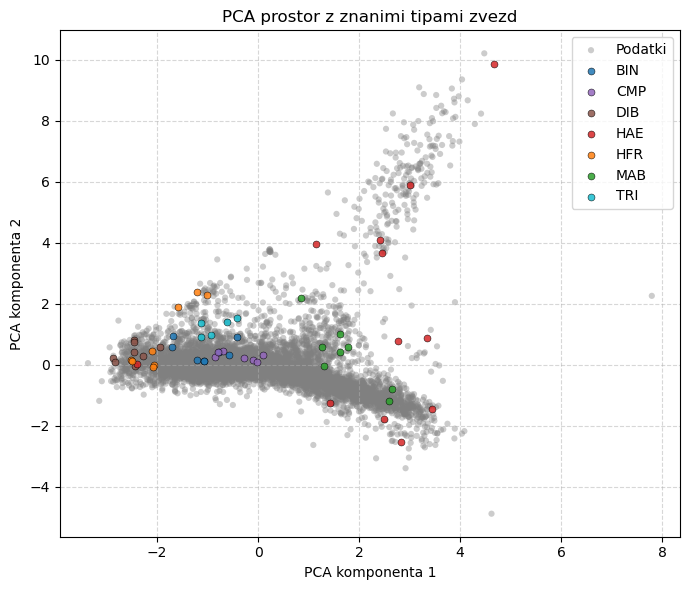

In [38]:
# Load training set types (spectrum_id, label)
type_data = np.loadtxt(path + "learning_set_types.txt", dtype=str)
type_ids = type_data[:, 0].astype(int)
type_labels = type_data[:, 1]

# Match labels to your loaded spectra
labels = []
for sid in spec_ids:
    if sid in type_ids:
        idx = np.where(type_ids == sid)[0][0]
        labels.append(type_labels[idx])
    else:
        labels.append("UNKNOWN")
labels = np.array(labels)

print("Labels for loaded spectra:", dict(zip(spec_ids, labels)))


# PCA COMPUTATION

# Center the data
B = X - np.mean(X, axis=0)
C = np.dot(B.T, B) / (X.shape[0] - 1)

# Eigen decomposition
eigvals, eigvecs = np.linalg.eig(C)
idx = np.argsort(eigvals)[::-1]
eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

# Project data to first 2 components
W = eigvecs[:, :2]
T = np.dot(B, W)


# DEFINE COLOR MAP FOR STAR TYPES

color_map = {
    "MAB": "tab:green",
    "BIN": "tab:blue",
    "TRI": "tab:cyan",
    "HFR": "tab:orange",
    "HAE": "tab:red",
    "CMP": "tab:purple",
    "DIB": "tab:brown",
    "UNKNOWN": "gray"
}

# Assign colors
colors = [color_map.get(lbl, "gray") for lbl in labels]


# PLOT PCA SPACE WITH CLASS COLORS

plt.figure(figsize=(7,6))

# Plot UNKNOWN types first (faded background)
mask_unknown = labels == "UNKNOWN"
if np.any(mask_unknown):
    plt.scatter(T[mask_unknown, 0], T[mask_unknown, 1],
                label="Podatki",
                c="gray",
                s=20,
                alpha=0.4,
                edgecolors='none',
                zorder=1)

# Plot known types on top
for lbl in np.unique(labels):
    if lbl == "UNKNOWN":
        continue
    mask = labels == lbl
    plt.scatter(T[mask, 0], T[mask, 1],
                label=lbl,
                c=color_map.get(lbl, "gray"),
                s=25,
                alpha=0.85,
                edgecolors='k',
                linewidth=0.4,
                zorder=2)

plt.xlabel("PCA komponenta 1")
plt.ylabel("PCA komponenta 2")
plt.title("PCA prostor z znanimi tipami zvezd")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# OPTIONAL: LOOK FOR PATTERNS WITH Teff OR METALLICITY

# If you already computed Teff, logg, [M/H] earlier:
# e.g., using Teff_match, logg_match, MH_match arrays
# You can check if specific classes occupy distinct parameter regions.

# Example (assuming Teff_match is defined):
# import pandas as pd
# df = pd.DataFrame({"Type": labels, "Teff": Teff_match})
# print(df.groupby("Type").mean())

# kernel PCA

In [ ]:
# Match loaded spectra with available labels
labels = []
for sid in spec_ids:
    if sid in type_ids:
        idx = np.where(type_ids == sid)[0][0]
        labels.append(type_labels[idx])
    else:
        labels.append("UNKNOWN")
labels = np.array(labels)

# Define color map for visualization
color_map = {
    "MAB": "tab:green",
    "BIN": "tab:blue",
    "TRI": "tab:cyan",
    "HFR": "tab:orange",
    "HAE": "tab:red",
    "CMP": "tab:purple",
    "DIB": "tab:brown",
    "UNKNOWN": "darkgray"
}
colors = [color_map.get(lbl, "gray") for lbl in labels]


# KERNEL PCA TRANSFORMATION

# Try nonlinear kernels — RBF usually works best for spectra
kpca = KernelPCA(n_components=101, kernel='rbf', gamma=0.01)
X_kpca = kpca.fit_transform(X)

# You can experiment with:
# kernel='poly', degree=3
# kernel='sigmoid'
# kernel='cosine'
# Adjust gamma for RBF if clusters are too tight or too loose


# VISUALIZE KERNEL PCA PROJECTION

plt.figure(figsize=(7,6))

# Plot UNKNOWN first (background)
mask_unknown = labels == "UNKNOWN"
if np.any(mask_unknown):
    plt.scatter(X_kpca[mask_unknown, 0], X_kpca[mask_unknown, 1],
                label="Podatki",
                c="gray",
                s=25,
                alpha=0.8,
                edgecolors='none',
                zorder=1)

# Plot known star types on top
for lbl in np.unique(labels):
    if lbl == "UNKNOWN":
        continue
    mask = labels == lbl
    plt.scatter(X_kpca[mask, 0], X_kpca[mask, 1],
                label=lbl,
                c=color_map.get(lbl,"darkgray"),
                s=40,
                alpha=0.9,
                edgecolors='k',
                linewidth=0.6,
                zorder=2)

# (Optional) Add outliers here if you identify any
# plt.scatter(X_kpca[outlier_idx, 0], X_kpca[outlier_idx, 1],
#             color='gold', s=100, marker='*',
#             edgecolors='k', linewidth=0.8,
#             label='Outliers', zorder=3)

plt.xlabel('Kernel PCA komponenta 1')
plt.ylabel('Kernel PCA komponenta 2')
plt.title('Kernel PCA projekcija (RBF kernel)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# OPTIONAL COMPARISON TO MANUAL PCA

# If you already have your manual PCA projection T (2D):
# Compare side-by-side visually or compute pairwise distances

# Example if T exists:
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.scatter(T[:,0], T[:,1], c=colors)
# plt.title("Linear PCA")
# plt.subplot(1,2,2)
# plt.scatter(X_kpca[:,0], X_kpca[:,1], c=colors)
# plt.title("Kernel PCA (RBF)")
# plt.show()
